In [8]:
%cd C:\Users\pinup\DL_Project

C:\Users\pinup\DL_Project


In [9]:
import pandas as pd
import numpy as np
import pickle
from zipfile import ZipFile
from pandas import read_csv
from PIL import Image
from io import BytesIO
import numpy as np
from pickle import dump, load
from cv2 import resize
import matplotlib.pyplot as plt

# IMAGE PREPROCESSING

In [19]:
archive = ZipFile(file="flickr_dataset.zip", mode="r")

df = read_csv("captions.csv", sep=",")
df = df.rename(columns=lambda x: x.strip())

IMAGELIST = df.loc[:, "image"].unique()

images = {}
start_idx = 0
end_idx = 10000


for (idx, label) in enumerate(IMAGELIST[start_idx : end_idx]):

    img = archive.read("Images/{}".format(label))
    img = BytesIO(img)
    img = np.asarray(Image.open(img))
    img = resize(img, (64,64))

    images[idx+start_idx] = img

result = np.array([images[key] for key in sorted(images.keys())])
with open('images1.pickle', 'wb') as file:
    dump(result, file)


del images
del file

# CAPTIONS SERIALIZING

In [20]:
archive = ZipFile(file="flickr_dataset.zip", mode="r")

df = read_csv("captions.csv", sep=",")
df = df.rename(columns=lambda x: x.strip())

IMAGELIST = df.loc[:, "image"].unique()

captions = {}

for (idx, label) in enumerate(IMAGELIST):
    captions[idx] = list(df.loc[df["image"] == label, "caption"].values)
    
with open('captions.pickle', 'wb') as file:
    dump(captions, file)

del file

result = [captions[key] for key in sorted(captions.keys())]
with open('captions.pickle', 'wb') as file:
    dump(result, file)

del file

# Loading the Images and Captions Pickle File

In [10]:
captions = pd.read_pickle(r'C:\Users\pinup\DL_Project\Captions.pickle')
images = pd.read_pickle(r'C:\Users\pinup\DL_Project\images1.pickle')

In [5]:
captions

[['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a girl with pigtails sitting in front of a rainbow painting .',
  'Young girl w

In [4]:
images.shape

(8091, 64, 64, 3)

In [5]:
len(captions)

8091

# Testing SKIP-THOUGHTS

In [8]:
import skipthoughts

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:
model = skipthoughts.load_model()
encoder = skipthoughts.Encoder(model)

Loading model parameters...
Compiling encoders...
Loading tables...
Packing up...


In [14]:
fun = lambda x: skipthoughts.encode(model, x) 
encoded_list = list(map(fun, captions[:100]))

In [26]:
encoded_list[99].shape

(5, 4800)

In [11]:
import utils
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pdb

# Generator

In [22]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F


class Generator(nn.Module):
    def __init__(self, batch_size, img_size, z_dim, text_embed_dim, text_reduced_dim):
        super(Generator, self).__init__()

        self.img_size = img_size
        self.z_dim = z_dim
        self.text_embed_dim = text_embed_dim

        self.concat = nn.Linear(z_dim + text_reduced_dim,512).cuda()
        self.text_reduced_dim = nn.Linear(text_embed_dim, text_reduced_dim).cuda()
        
        # Defining the generator network architecture
        self.d_net = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        ).cuda()

    def forward(self, text, z):
        """ Given a caption embedding and latent variable z(noise), generate an image
        Arguments
        ---------
        text : torch.FloatTensor
            Output of the skipthought embedding model for the caption
            text.size() = (batch_size, text_embed_dim)
        z : torch.FloatTensor
            Latent variable or noise
            z.size() = (batch_size, z_dim)
        --------
        Returns
        --------
        output : An image of shape (64, 64, 3)
        """
        reduced_text = self.text_reduced_dim(text.cuda())  # (batch_size, text_reduced_dim)
        concat = torch.cat((reduced_text, z.cuda()), 1)  # (batch_size, text_reduced_dim + z_dim)
        concat = self.concat(concat)  # (batch_size, 64*8*4*4)
        concat = concat.view(-1, 4, 4, 64 * 8)  # (batch_size, 4, 4, 64*8)
        
        concat = concat.permute(0, 3, 1, 2) # (batch_size, 512, 4, 4)
        d_net_out = self.d_net(concat)  # (batch_size, 3, 64, 64)
        d_net_out = d_net_out.permute(0, 2, 3, 1) #(batch_size, 64, 64, 3)
        
        output = d_net_out / 2. + 0.5   # (batch_size, 64, 64, 3)

        return output

# Discriminator

In [23]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F


class Discriminator(nn.Module):
    def __init__(self, batch_size, img_size, text_embed_dim, text_reduced_dim):
        super(Discriminator, self).__init__()

        self.batch_size = batch_size
        self.img_size = img_size
        self.in_channels = img_size[2]
        self.text_embed_dim = text_embed_dim
        self.text_reduced_dim = text_reduced_dim

        # Defining the discriminator network architecture
        self.d_net = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)).cuda()

        # output_dim = (batch_size, 4, 4, 512)
        # text.size() = (batch_size, text_embed_dim)

        # Defining a linear layer to reduce the dimensionality of caption embedding
        # from text_embed_dim to text_reduced_dim

        self.cat_net = nn.Sequential(
            nn.Conv2d(512 + self.text_reduced_dim, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)).cuda()

        self.text_reduced_dim = nn.Linear(self.text_embed_dim, self.text_reduced_dim).cuda()
        
        self.linear = nn.Linear(2 * 2 * 512, 1).cuda()

    def forward(self, image, text):
        """ Given the image and its caption embedding, predict whether the image
        is real or fake.
        Arguments
        ---------
        image : torch.FloatTensor
            image.size() = (batch_size, 64, 64, 3)
        text : torch.FloatTensor
            Output of the skipthought embedding model for the caption
            text.size() = (batch_size, text_embed_dim)
        --------
        Returns
        --------
        output : Probability for the image being real/fake
        logit : Final score of the discriminator
        """
        image = image.permute(0, 3, 1, 2) # (batch_size, 3, 64, 64)
        d_net_out = self.d_net(image)  # (batch_size, 512, 4, 4)
        d_net_out = d_net_out.permute(0, 2, 3, 1) # (batch_size, 4, 4, 512)
        
        text_reduced = self.text_reduced_dim(text)  # (batch_size, text_reduced_dim)
        text_reduced = text_reduced.unsqueeze(1)  # (batch_size, 1, text_reduced_dim)
        text_reduced = text_reduced.unsqueeze(2)  # (batch_size, 1, 1, text_reduced_dim)
        text_reduced = text_reduced.expand(-1, 4, 4, -1)

        concat_out = torch.cat((d_net_out, text_reduced), 3)  # (1, 4, 4, 512+text_reduced_dim)
        
        logit = self.cat_net(concat_out.permute(0, 3, 1, 2))
        logit = logit.reshape(-1, logit.size()[1] * logit.size()[2] * logit.size()[3])
        logit = self.linear(logit)

        output = torch.sigmoid(logit)

        return output, logit

# Hyperparameters

In [24]:
batch_size=5
img_size=images[1].shape
z_dim=100
text_embed_dim=4800
text_reduced_dim=512
learning_rate=3e-4
start_epoch=0
num_epochs=2

# NETWORK INITIALIZATION

In [25]:
import torch.optim as optim
import itertools

In [26]:
#Networks Initializing

#Generator
gen = Generator(batch_size=batch_size,img_size=img_size, z_dim=z_dim,text_embed_dim=text_embed_dim,text_reduced_dim=text_reduced_dim)

disc = Discriminator(batch_size=batch_size,  img_size=img_size,  text_embed_dim=text_embed_dim,text_reduced_dim=text_reduced_dim)

gen_optim = optim.Adam(gen.parameters(),lr=learning_rate)
disc_optim = optim.Adam(disc.parameters(), lr=learning_rate)


# PRINT MODELS

In [17]:
def print_network(model, name):
    """ A function for printing total number of model parameters """
    num_params = 0
    for p in model.parameters():
        num_params += p.numel()
        print(model)
        print(name)
        print("Total number of parameters: {}".format(num_params))

In [18]:
#PRINT GENERATOR
print_network(gen, 'G')

generator(
  (projection): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (netG): Sequential(
    (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


generator(
  (projection): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (netG): Sequential(
    (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


# Data Loader Testing

In [27]:
import dataloader

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [28]:
data_loader1=dataloader.Text2ImageDataset()

Loading model parameters...
Compiling encoders...
Loading tables...


MemoryError: 

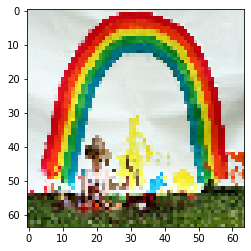

In [13]:
plt.imshow(data_loader1.read_image(2))

In [15]:
data_loader1.read_image(2).shape

(64, 64, 3)

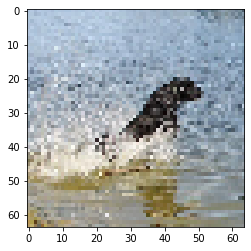

In [19]:
plt.imshow(data_loader1.false_image(2))

In [47]:
for idx,batch in enumerate(data_loader1):
    print(idx,batch['true_imgs'].shape)
    print(idx,batch['true_embds'].shape)
    print(idx,batch['false_imgs'].shape)
    text=batch['true_embds']
    break

0 torch.Size([64, 64, 3])
0 torch.Size([4800])
0 torch.Size([64, 64, 3])


# Training

In [14]:
import numpy as np
from torch import nn
from torch import  autograd
import torch
import os
import pdb

In [15]:
def smooth_label(tensor, offset):
        return tensor + offset

In [16]:
scriterion = nn.BCELoss().cuda()
gen.train()

Generator(
  (concat): Linear(in_features=612, out_features=8192, bias=True)
  (text_reduced_dim): Linear(in_features=4800, out_features=512, bias=True)
  (d_net): Sequential(
    (0): ReLU()
    (1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): Tanh()
  )
)

In [17]:
disc.train()

Discriminator(
  (d_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (cat_net): Sequential(
    (0): Conv2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1):

In [ ]:
for epoch in range(start_epoch, num_epochs):
    print("Epoch: {}".format(epoch+1))
    for idx, batch in enumerate(data_loader1):
        print("Index: {}".format(idx+1), end = "\t")
        true_imgs = batch['true_imgs']
        true_embed = batch['true_embds']
        false_imgs = batch['false_imgs']
        real_labels = torch.ones(true_imgs.size(0))
        fake_labels = torch.zeros(true_imgs.size(0))
        smooth_real_labels = torch.FloatTensor(smooth_label(tensor=real_labels.numpy(),offset=-0.1))
        true_imgs = Variable(true_imgs.float()).cuda()
        true_embed = Variable(true_embed.float()).cuda()
        false_imgs = Variable(false_imgs.float()).cuda()
        real_labels = Variable(real_labels).cuda()
        smooth_real_labels = Variable(smooth_real_labels).cuda()
        fake_labels = Variable(fake_labels).cuda()
        
        #GENERATOR
        gen.zero_grad()
        z = Variable(torch.randn(true_imgs.size(0), z_dim)).cuda()
        fake_imgs = gen.forward(batch['true_embds'], z)
        fake_out, fake_logit = disc.forward(fake_imgs, true_embed)
        fake_out = Variable(fake_out.data, requires_grad=True).cuda()
        true_out, true_logit = disc.forward(true_imgs, true_embed)
        true_out = Variable(true_out.data, requires_grad=True).cuda()
        g_sf = self.criterion(fake_out, real_labels)
        gen_loss = g_sf
        gen_loss.backward()
        self.gen_optim.step()
        
        #DISCRIMINATOR
        self.disc.zero_grad()
        false_out, false_logit = disc.forward(false_imgs, true_embed)
        false_out = Variable(false_out.data, requires_grad=True)
        sr = criterion(true_out, smooth_real_labels)
        sw = criterion(true_out, fake_labels)
        sf = criterion(false_out, smooth_real_labels)
        disc_loss =  torch.log(sr) + (torch.log(1-sw) + torch.log(1-sf ))/2 
        disc_loss.backward()
        disc_optim.step()
        cls_gan_optim.step()